# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from sklearn.preprocessing import  StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats
# magic word for producing visualizations in notebook
%matplotlib inline

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv(r'C:\Users\Kimo Store\Downloads\arvato\Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv(r'C:\Users\Kimo Store\Downloads\arvato\AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# rows and columns, print the first few rows).
print("Total number of rows in azdias dataframe is {}".format(azdias.shape[0]))
print("Total number of columns in azdias dataframe is {}".format(azdias.shape[1]))

Total number of rows in azdias dataframe is 891221
Total number of columns in azdias dataframe is 85


In [4]:
# Check the structure of the data after it's loaded
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


**We have large number of columns so i will use transpose to view structure of data in good way**

In [5]:
azdias.head().T

,0,1,2,3,4
AGER_TYP,-1,-1,-1,2,-1
ALTERSKATEGORIE_GROB,2,1,3,4,3
ANREDE_KZ,1,2,2,2,1
CJT_GESAMTTYP,2,5,3,2,5
FINANZ_MINIMALIST,3,1,1,4,4
FINANZ_SPARER,4,5,4,2,3
FINANZ_VORSORGER,3,2,1,5,4
FINANZ_ANLEGER,5,5,2,2,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3
FINANZ_HAUSBAUER,3,5,5,2,2


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [8]:
# print total number of rows and columns in feat_info

print("Total number of rows in feat_info dataframe is {}".format(feat_info.shape[0]))
print("Total number of columns in feat_info dataframe is {}".format(feat_info.shape[1]))

Total number of rows in feat_info dataframe is 85
Total number of columns in feat_info dataframe is 4


In [9]:
# let's see each column in or dataset refere to what
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
null_data = azdias.isnull().sum()[azdias.isnull().sum() != 0]

data_dict = {'count': null_data.values, 'pct':np.round(null_data.values *100/891221,2)}

init_null = pd.DataFrame(data=data_dict, index=null_data.index)
init_null.sort_values(by='count', ascending=False, inplace=True)
init_null

,count,pct
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,133324,14.96
KBA05_ANTG4,133324,14.96
KBA05_ANTG1,133324,14.96
KBA05_ANTG2,133324,14.96
KBA05_GBZ,133324,14.96
MOBI_REGIO,133324,14.96
KBA05_ANTG3,133324,14.96
KKK,121196,13.60
REGIOTYP,121196,13.60


In [11]:
for my_attribute in feat_info['attribute']:

    tmp_list = feat_info[feat_info['attribute']==my_attribute].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
    missing_or_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in tmp_list]    
    azdias[my_attribute].replace(to_replace=missing_or_unknown_list,
                      value=np.nan, inplace=True)

**The above cell i use it from this github [repo](https://github.com/joshuayeung/Creating-Customer-Segments-with-Arvato/blob/master/Identify_Customer_Segments.ipynb)**

In [12]:
null_data_after = azdias.isnull().sum()[azdias.isnull().sum() != 0]

data_dict_after = {'count': null_data_after.values, 'pct':np.round(null_data_after.values *100/891221,2)}

null_after = pd.DataFrame(data=data_dict_after, index=null_data_after.index)
null_after.sort_values(by='count', ascending=False, inplace=True)
null_after

,count,pct
TITEL_KZ,889061,99.76
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
ALTER_HH,310267,34.81
REGIOTYP,158064,17.74
KKK,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_GBZ,133324,14.96
KBA05_ANTG4,133324,14.96
KBA05_ANTG3,133324,14.96


### before we map between values in feat_info to nan values the percentage of null changed so our mapping is ok

**After investigating our data set which consists of 85 columns so if we try to visualize nulls in each column for all together this not a good visualization so i will visualize each 15 columns together**

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

Text(0.5, 1.0, 'Histogram of missing value counts')

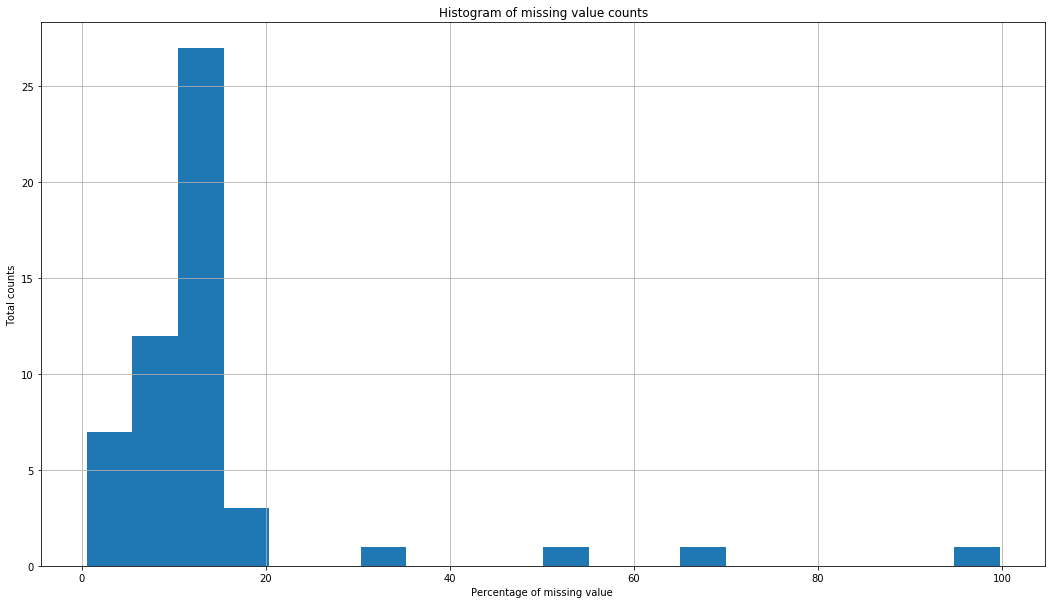

In [13]:
null_after.pct.hist(figsize=(18,10), bins=20)
plt.xlabel('Percentage of missing value ')
plt.ylabel('Total counts')
plt.title('Histogram of missing value counts')

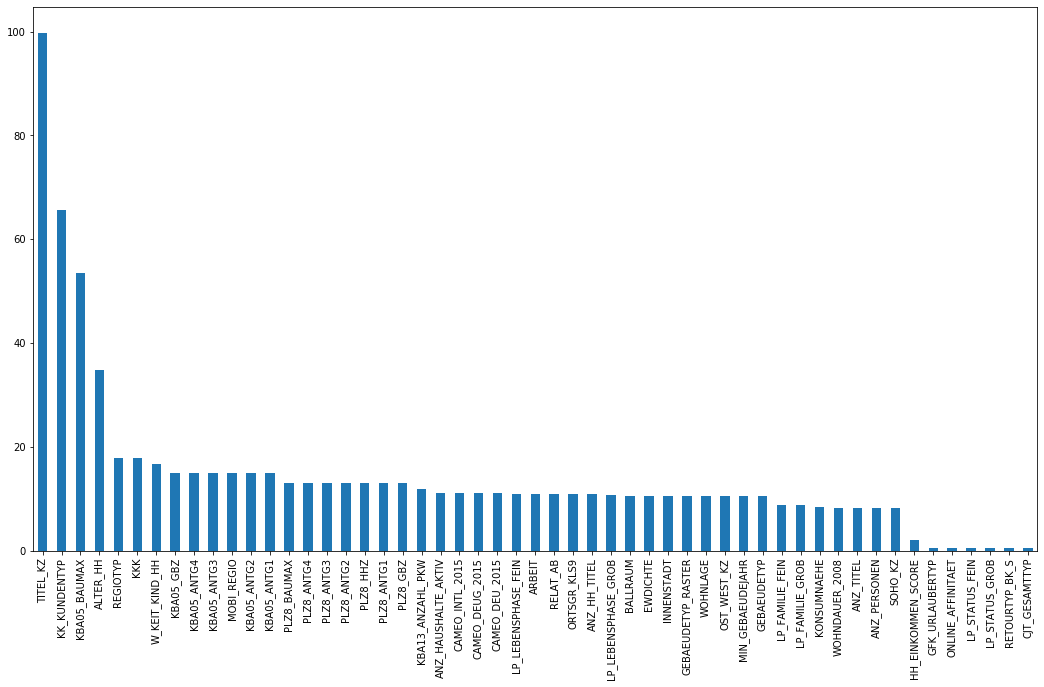

In [14]:
# Investigate patterns in the amount of missing data in each column.
null_after.pct.plot.bar(figsize=(18,10))

###### After looking at counts of missing values in each columns i decided that columns with more than 35% of missing values i will drop them as they are meaningless there are about 5 or 6 columns which are:
<br>
<br>


<font size=3.5>


1. TITEL_KZ	
2. AGER_TYP	
3. KK_KUNDENTYP	
4. KBA05_BAUMAX	
5. GEBURTSJAHR	

</font>

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

columns = ['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']
azdias = azdias.drop(columns, axis=1)
feat_info = feat_info[~feat_info['attribute'].isin(columns)]


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

**Answer**

**'TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR'** these columns contain very high percentage of missing values 

**RETOURTYP_BK_S, LP_STATUS_GROB, LP_STATUS_FEIN, GFK_URLAUBERTYP, CJT_GESAMTTYP, ONLINE_AFFINITAET, ALTERSKATEGORIE_GROB**

These columns have missing values percentage less than 1% 

**Rest of columns have missing values between 35% and 8.5%**

**Some groups of similar columns have a similar number of missing values. For example, columns starting with PLZ8 are misssing 13.07% of their values.**



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [16]:
# How much data is missing in each row of the dataset?

rows_nulls = azdias.isnull().sum(axis=1)

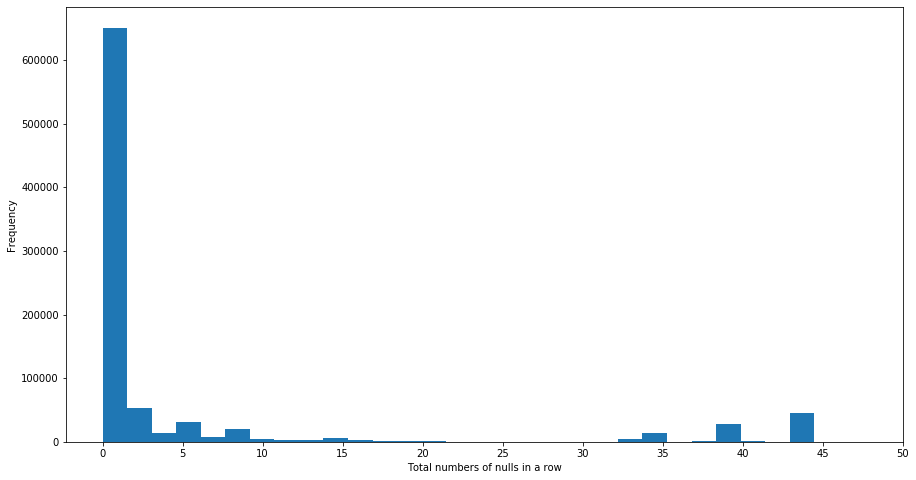

In [17]:
rows_nulls.plot.hist(bins=30,figsize=(15,8))
plt.xlabel("Total numbers of nulls in a row")
plt.xticks(np.arange(0,55,5));


**Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold. i will use threshold arround 25**

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

rows_many_missing = rows_nulls[rows_nulls> 25]
rows_many_missing_pct = (rows_many_missing.shape[0]/rows_nulls.shape[0])*100
print('Total numer of rows with high missing values above 25 columns are {} or as percentage {}%'.format(rows_many_missing.shape[0],round(rows_many_missing_pct,3)))

Total numer of rows with high missing values above 25 columns are 93228 or as percentage 10.461%


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
less_missing_columns=list(null_after[-5:].index)

def plot_compare(column):
    fig = plt.figure(figsize=(14,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Many missing rows')
    sns.countplot(azdias.loc[rows_many_missing.index,column])

    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Few missing rows')
    sns.countplot(azdias.loc[~azdias.index.isin(rows_many_missing.index),column]);

    fig.suptitle(column)
    plt.show()
    print(stats.ks_2samp(azdias.loc[rows_many_missing.index,column],azdias.loc[rows_many_missing.index,column]))

**The above cell i use it from this github [repo](https://github.com/MiguelAMartinez/identify-customer-segments-Arvato/blob/master/Identify_Customer_Segments.ipynb)**

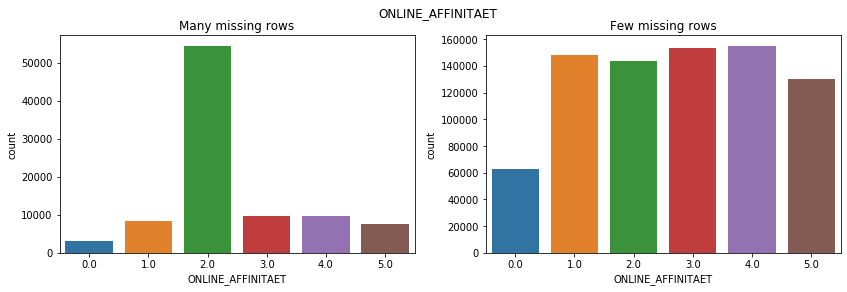

Ks_2sampResult(statistic=-0.0, pvalue=1.0)


In [20]:
plot_compare(less_missing_columns[0])

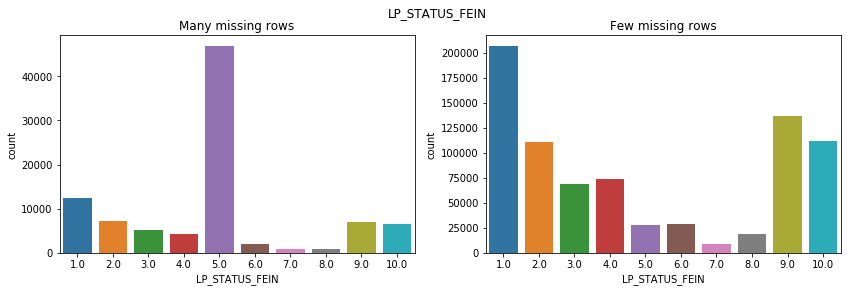

Ks_2sampResult(statistic=-0.0, pvalue=1.0)


In [21]:
plot_compare(less_missing_columns[1])

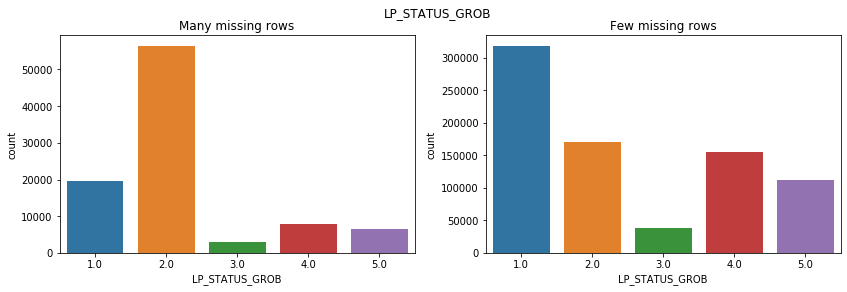

Ks_2sampResult(statistic=-0.0, pvalue=1.0)


In [22]:
plot_compare(less_missing_columns[2])

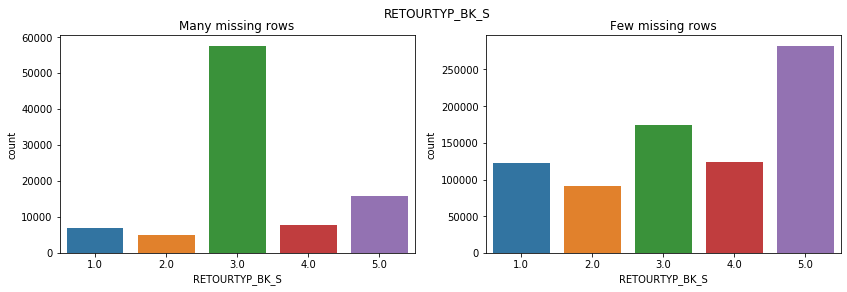

Ks_2sampResult(statistic=-0.0, pvalue=1.0)


In [23]:
plot_compare(less_missing_columns[3])

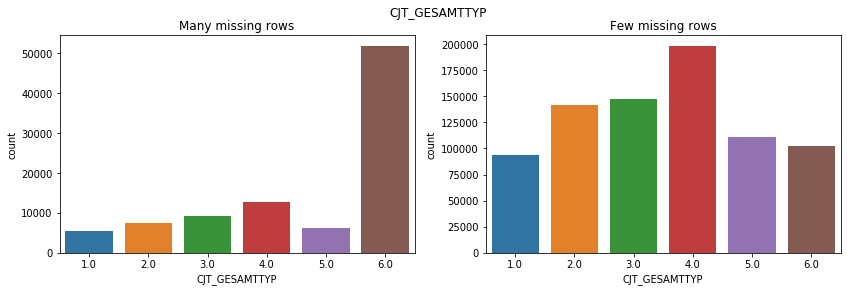

Ks_2sampResult(statistic=-0.0, pvalue=1.0)


In [24]:
plot_compare(less_missing_columns[4])

#### Discussion 1.1.3: Assess Missing Data in Each Row
<br>
<font size=3.5>

after dividing the dataset into 2 parts one for low missing rows and other for high missing rows and plot countplot between both then i use **ks_2samp** which Compute the Kolmogorov-Smirnov statistic on 2 samples.

This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution. The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. [Reference](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) i found that both distributions are different according to the very high **P-value** This means that there is a pattern in the way that data is missing, and thus taking out rows with null values would introduce bias. for further reading about [**P-value**](https://en.wikipedia.org/wiki/P-value)

</font>

In [25]:
azdias.shape

(891221, 80)

In [26]:
azdias =azdias[~azdias.index.isin(rows_many_missing)]


In [27]:
azdias.shape

(891201, 80)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_feats = feat_info[feat_info['type'] == 'categorical']['attribute']
categorical_feats


2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [29]:
# first we need to find list of binary categorical columns and multi categorical columns 

binary_cats=[]
multi_cats=[]
for i in categorical_feats:
    if azdias[i].nunique() > 2:
        multi_cats.append(i)
    else:
        binary_cats.append(i)

In [30]:
print("INVESTIGATE BINARY CATEGORICAL DATA")
for binary in binary_cats:
    print(azdias[binary].value_counts())
    print("\n")

print("\n")
print("INVESTIGATE MULTI-LEVEL CATEGORICAL DATA")    

for multi in multi_cats:
    print(azdias[multi].value_counts())
    print("\n")

INVESTIGATE BINARY CATEGORICAL DATA
2    465291
1    425910
Name: ANREDE_KZ, dtype: int64


0    715982
1    175219
Name: GREEN_AVANTGARDE, dtype: int64


0.0    810815
1.0      6888
Name: SOHO_KZ, dtype: int64


W    629511
O    168545
Name: OST_WEST_KZ, dtype: int64




INVESTIGATE MULTI-LEVEL CATEGORICAL DATA
4.0    210957
3.0    156445
6.0    153913
2.0    148789
5.0    117376
1.0     98867
Name: CJT_GESAMTTYP, dtype: int64


6    290361
1    199568
4    130623
2    110865
5    106434
3     53350
Name: FINANZTYP, dtype: int64


12.0    138545
5.0     120121
10.0    109124
8.0      88041
11.0     79738
4.0      63769
9.0      60613
3.0      56007
1.0      53596
2.0      46701
7.0      42954
6.0      27138
Name: GFK_URLAUBERTYP, dtype: int64


1.0     426367
10.0    137911
2.0     104303
11.0     51716
8.0      23032
7.0      20729
4.0      12303
5.0      11920
9.0      11148
6.0       9022
3.0       4958
Name: LP_FAMILIE_FEIN, dtype: int64


1.0    426367
5.0    200775
2.0    104303

In [31]:
azdias.shape

(891201, 80)

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Fisrt encode binary categorical variable
azdias['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
azdias['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
# Second encode multi-level categorical variable
azdias = pd.get_dummies(azdias, columns=multi_cats)


In [33]:
azdias.shape

(891201, 199)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<br>
<font size =3.5>

1. I didn't drop any categorical column
2. I use 0/1 for binary categorical variable to encode the two levels
3. I use [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to encode multi-level categorical variables

</font>

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias[['PRAEGENDE_JUGENDJAHRE']].head()

,PRAEGENDE_JUGENDJAHRE
0,0
1,14
2,15
3,8
4,8


In [35]:
# Generation 
gens = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s

# Movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def classify_generation(value):
    try:
        for key, values in gens.items():
            if value in values:
                return key
    except ValueError:
        return np.nan    

def classify_movement(value):
    try:
        if value in mainstream:
            return 1
        else:
            return 0
    except ValueError:
        return np.nan

In [36]:
azdias['PRAEGENDE_JUGENDJAHRE_Generation'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
azdias['PRAEGENDE_JUGENDJAHRE_Move'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

In [37]:
# Sanity check

azdias[['PRAEGENDE_JUGENDJAHRE_Generation','PRAEGENDE_JUGENDJAHRE_Move']].sample(20)

,PRAEGENDE_JUGENDJAHRE_Generation,PRAEGENDE_JUGENDJAHRE_Move
81645,3.0,1
104428,3.0,1
476847,2.0,1
612158,NaN,0
221622,4.0,1
794873,2.0,1
604968,4.0,1
441223,2.0,1
718924,5.0,1
112577,5.0,0


**Afte looking at data_dictionary.md to figure out what is the meaning of each number in this cilumn i figure out the following 
this column consist of 2 digit number the first digit for first digit -> wealth and second digit -> life stage**

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

def extract_wealth(x):
    # Check of nan first
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

def extract_lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [39]:
azdias['CAMEO_INTL_2015_wealth'] = azdias['CAMEO_INTL_2015'].apply(extract_wealth)
azdias['CAMEO_INTL_2015_lifestage'] = azdias['CAMEO_INTL_2015'].apply(extract_lifestage)

In [40]:
azdias.shape

(891201, 203)

In [41]:
mixed = ['PRAEGENDE_JUGENDJAHRE','LP_LEBENSPHASE_FEIN',
         'LP_LEBENSPHASE_GROB','WOHNLAGE','PLZ8_BAUMAX','CAMEO_INTL_2015']

azdias.drop(columns= mixed,axis=1,inplace = True)

In [42]:
azdias.shape

(891201, 197)

#### Discussion 1.2.2: Engineer Mixed-Type Features

<br>
<font size =3>

1. I split the 2 columns **PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.** into 4 columns which are **'PRAEGENDE_JUGENDJAHRE_Generation','PRAEGENDE_JUGENDJAHRE_Move','CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_lifestage'**
<br>

2. I drop the rest of mixed type columns as they are not important for my analysis
<br>

3. The new features are ordinal, and thus don't need to be one hot encoded. The two original columns were then dropped.
</font>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [43]:
# Fast check for dtype
azdias.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [44]:
def clean_data(data,feature):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
   
    for my_attribute in feature['attribute']:
        tmp_list = feature[feature['attribute']==my_attribute].missing_or_unknown.iloc[0].replace('[','').replace(']','').split(',')
        missing_or_unknown_list = [float(x) if x.lstrip('-').isnumeric() else x for x in tmp_list]    
        data[my_attribute].replace(missing_or_unknown_list,np.nan, inplace=True)

    # remove selected columns and rows, ...
    
    dropped_columns =['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR']
    data.drop(columns=dropped_columns,axis=1)
    feature = feature[~feature['attribute'].isin(columns)]
    rows_nulls = data.isnull().sum(axis=1)
    rows_many_missing = rows_nulls[rows_nulls> 25]
    data_many_missing = data.iloc[rows_many_missing.index]
    data =data[~data.index.isin(rows_many_missing)]
   
    # select, re-encode, and engineer column values.
    
    categorical_feats = feature[feature['type'] == 'categorical']['attribute']
    binary_cats=[]
    multi_cats=[]
    
    for i in categorical_feats:
        if data[i].nunique() > 2:
            multi_cats.append(i)
        else:
            binary_cats.append(i)

    # Fisrt encode binary categorical variable
    
    data['ANREDE_KZ'].replace([2,1], [1,0], inplace=True)
    data['VERS_TYP'].replace([2.0,1.0], [1,0], inplace=True)
    data['OST_WEST_KZ'].replace(['W','O'], [1,0], inplace=True)
    
    # Second encode multi-level categorical variable
    data = pd.get_dummies(data, columns=multi_cats)
    
    # Third encode mixed columns

    data['PRAEGENDE_JUGENDJAHRE_decade'] = data['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
    data['PRAEGENDE_JUGENDJAHRE_movement'] = data['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
    
    data['CAMEO_INTL_2015_wealth'] = data['CAMEO_INTL_2015'].apply(extract_wealth)
    data['CAMEO_INTL_2015_lifestage'] = data['CAMEO_INTL_2015'].apply(extract_lifestage)
    
    
    data = data.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015','LP_LEBENSPHASE_FEIN',
         'LP_LEBENSPHASE_GROB','WOHNLAGE','KBA05_BAUMAX','PLZ8_BAUMAX'], axis=1)

    # Return the cleaned dataframe.
    
    return data, data_many_missing

In [45]:
azdias.dropna(thresh=0.15,inplace = True)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [46]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer =SimpleImputer(strategy = "mean")
azdias_imputed = imputer.fit_transform(azdias)


In [47]:
# Apply feature scaling to the general population demographics data.
my_scaler = StandardScaler()
azdias_std = my_scaler.fit_transform(azdias_imputed)


### Discussion 2.1: Apply Feature Scaling

<br>

<font size =3>
    
1. First i impute missing values with the mean 
<br>

2. Then i use StandardScaler which return values its mean is 0 and standard deviation of 1 and you can read about it from [Here](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
</font>

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [48]:
# Apply PCA to the data.

pca = PCA()
pca_result = pca.fit_transform(azdias_std)

In [49]:

# Investigate the variance accounted for by each principal component.

# I use this functions from the course itself after some modification

def scree_plot(pca, components_no=None, show_labels=False):

    vals = pca.explained_variance_ratio_
    if components_no:
        vals = vals[:components_no]
    num_components = len(vals)
    ind = np.arange(num_components)
 
    plt.figure(figsize=(18, 15))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    
    if show_labels:
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Percentage of Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

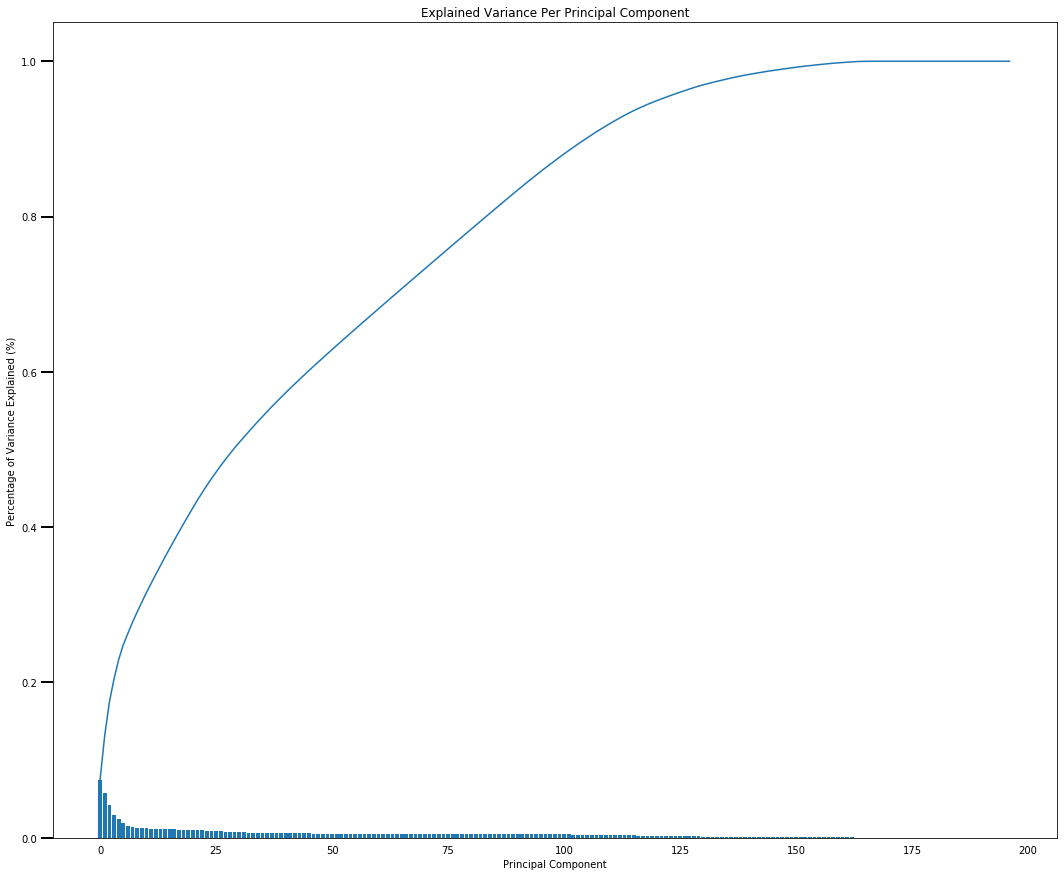

In [50]:
# Re-apply PCA to the data while selecting for number of components to retain.

scree_plot(pca)

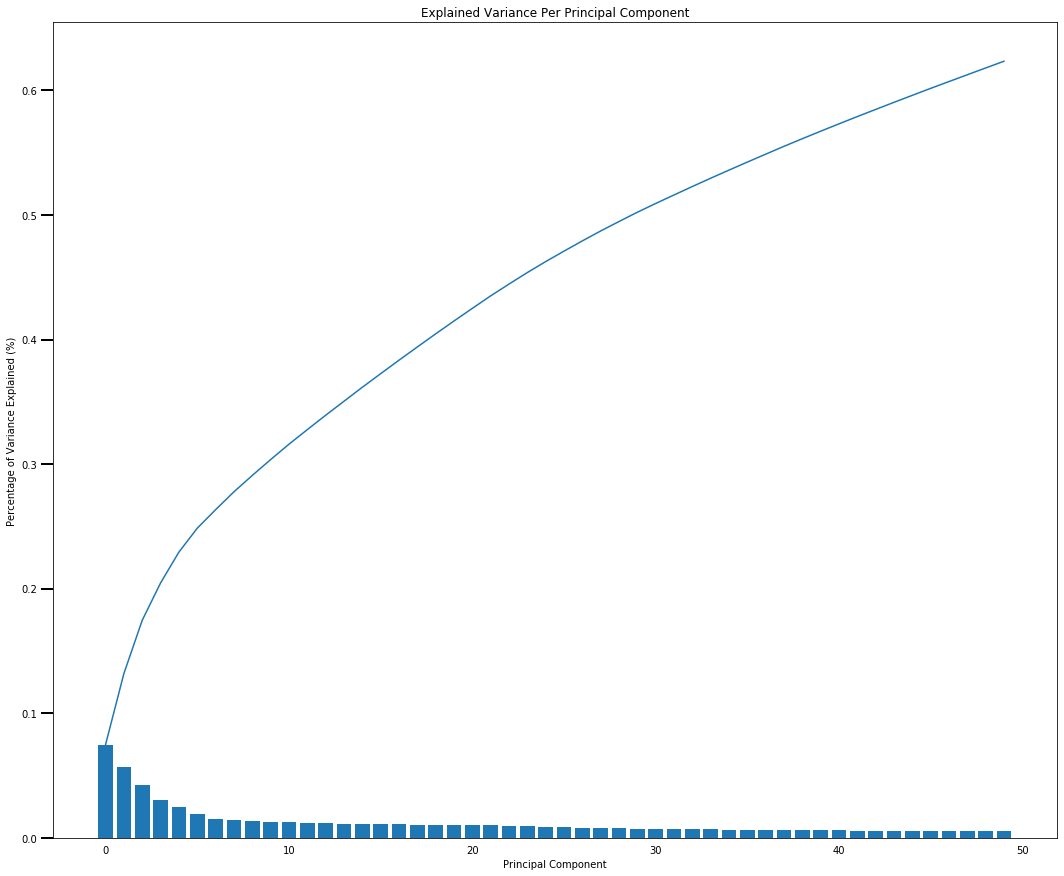

In [51]:
scree_plot(pca,components_no=50)

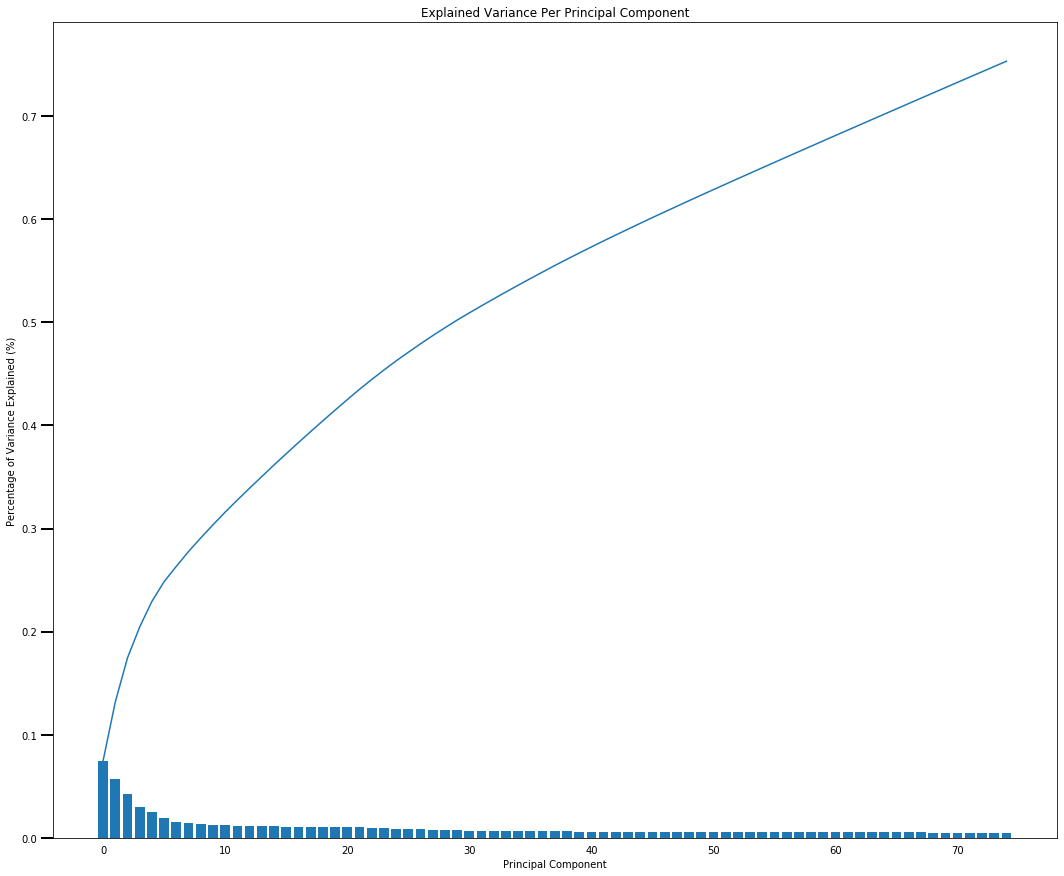

In [52]:
scree_plot(pca,components_no=75)

lets investigate contribution for each 15 pca to overall variance percentage explained

In [53]:
for i in np.arange(15, 76, 15):
    print('{} components explain {} of overall variance percentage.'.format(i,round(pca.explained_variance_ratio_[:i].sum(),3)))

15 components explain 0.362 of overall variance percentage.
30 components explain 0.502 of overall variance percentage.
45 components explain 0.596 of overall variance percentage.
60 components explain 0.676 of overall variance percentage.
75 components explain 0.753 of overall variance percentage.


In [54]:
azdias.shape[1]

197

In [55]:
# re-apply PCA with defiened number of componetnt to retain
pca = PCA(n_components=75)
pca_result_2 = pca.fit_transform(azdias_std)

### Discussion 2.2: Perform Dimensionality Reduction

1. we have 203 original feature in our dataset all of them explain the overall variance
2. when i use number of components = 50 it explained about 59%
3. i decide to use 75 components to explain about 75% which is good 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [56]:
def component_plot(data, pca, n_compo):

    component = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_compo-1]
    component.sort_values(ascending=False, inplace=True)
    component = pd.concat([component.head(5), component.tail(5)])
    
    component.plot(kind='bar', title='Component ' + str(n_compo))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()

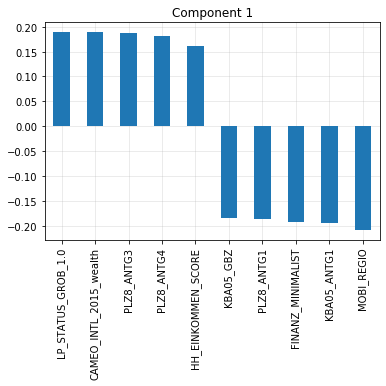

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

component_plot(azdias,pca,1)

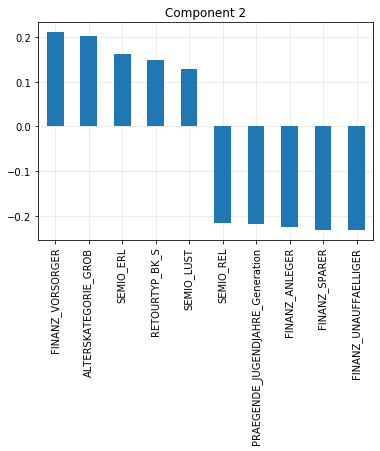

In [58]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_plot(azdias,pca,2)


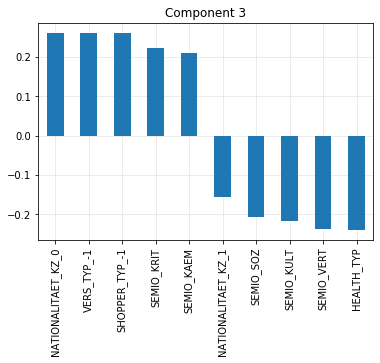

In [59]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
component_plot(azdias,pca,3)



SEMIO_SOZ: Personality typology, socially-minded (higher is lower affinity)
SEMIO_VERT: Personality typology, dreamful (higher is lower affinity)


### Discussion 2.3: Interpret Principal Components

**First Dimension:**

<br>
<font size = 3>
The first dimension is in positive association with the following feature:
</font>

1. **CAMEO_INTL_2015_wealth:** Household wealth (higher is lower income)

2. **PLZ8_ANTG3:** Number of 6-10 family houses in the PLZ8 region

3. **PLZ8_ANTG4:**  Number of 10+ family houses in the PLZ8 region

4. **HH_EINKOMMEN_SCORE:** Estimated household net income (higher is lower income)

5. **LP_STATUS_GROB_1.0:** Social status, rough scale low-income earners (maps to 1-2 in fine scale)

<font size = 3>
The first dimension is in negative association with the following feature 
</font>

1. **KBA05_GBZ:** Number of buildings in the microcell
 
2. **PLZ8_ANTG1:** Number of 1-2 family houses in the PLZ8 region
 
3. **FINANZ_MINIMALIST:** Financial topology, low financial interest (higher is lower topology)
 
4. **MOBI_REGIO:** Movement patterns (higher is lower movement)

5. **KBA05_ANTG1**: Number of 1-2 family houses in the microcell (higher is higher share of 1-2 family homes in cell)

<br>

**Second Dimension:**

<br>
<font size=3>
The second dimension is in positive association with the following feature 
</font>

1. **FINANZ_VORSORGER:** (Financial typology / prevention level)

2. **ALTERSKATEGORIE_GROB:** (Estimated age based on given name analysis)

3. **SEMIO_ERL:** (Event-oriented personality type)

4. **RETOURTYP_BK_S:** (product return type of personality)

5. **SEMIO_KAEM:** PERSONALITY TOPOLOGY (combative attitude)


<br>
<font size =3>
The second dimension is in negative association with the following feature 
</font>

1. **PRAEGENDE_JUGENDJAHRE_Generation:** Generation of population

2. **FINANZ_SPARER:** (Financial typology / hoarding level)

3. **FINANZ_UNAUFFAELLIGER:** (Financial typology / noticeability level)

4. **SEMIO_REL:** (Religious personality type)

5. **FINANZ_ANLEGER:** Financial typology, for investor

<br>

**Third Dimension:**

<br>
<font size =3>
The third dimension is in positive association with the following feature 
</font>

1. **SEMIO_KAEM:** Personality typology, combative attitude (higher is lower affinity)

2. **NATIONALITAET_KZ:** Nationality based on given name analysis 0 for UNKOWN

3. **SHOPPER_TYP:** Shopper typology unknown

4. **SEMIO_KRIT:** Personality typology, for critical-minded

5. **VERS_TYP_1:** Insurance typology for the unknown

<br>
<font size =3>
The third dimension is in negative association with the following feature 
</font>  

1. **SEMIO_VERT:** Personality typology, dreamful (higher is lower affinity)

2. **SEMIO_KULT:** Personality typology, - KULT: cultural-minded

3. **SEMIO_SOZ:** Personality typology, socially-minded (higher is lower affinity)

4. **HEALTH_TYP_1:** Health typology for unkonw

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [60]:
# i will use a sample from the entire population due to my PC limited resources i will use 35% of population
sample = pca_result_2 [np.random.choice(pca_result_2.shape[0],int(pca_result_2 .shape[0]*0.25), replace=False)]

In [61]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    
SSE=[]
K_means = np.arange(10,31)

for k in tqdm(K_means):
    Kmeans= KMeans(k, random_state=123, max_iter=30).fit(sample)
    SSE.append(np.abs(Kmeans.score(sample)))


100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [44:29<00:00, 127.10s/it]


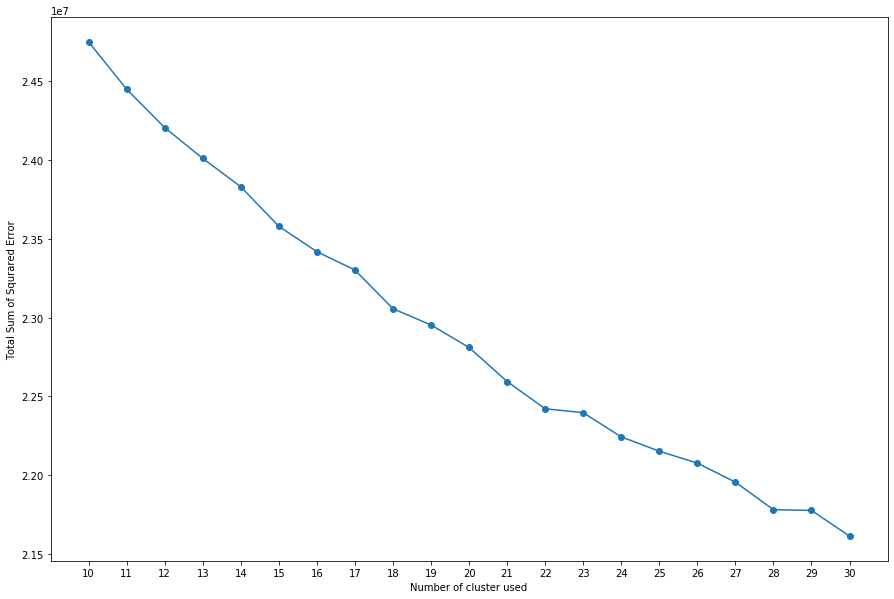

In [62]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.figure(figsize=(15,10))    
plt.xticks(np.arange(10, 31, step=1))
plt.plot(K_means, SSE, marker='o');
plt.xlabel('Number of cluster used');
plt.ylabel('Total Sum of Squrared Error');

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

Kmeans_population = KMeans(n_clusters=28,random_state=123,max_iter=30).fit(pca_result_2)
clustering_population = Kmeans_population.predict(pca_result_2)

### Discussion 3.1: Apply Clustering to General Population

**First**

i use random sample for 25% of population and run a for loop while changing number of clusters (k) from 10 to 30 but Unfortunately there is no clearly distinguishable elbow in the plot, but i choose **k=28** 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
customers = pd.read_csv(r'C:\Users\Kimo Store\Downloads\arvato\Udacity_CUSTOMERS_Subset.csv', sep=';')


In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean, customers_many_missing  = clean_data(customers,feat_info)


C:\Users\Kimo Store\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [67]:
customers_clean.dropna(inplace = True)

In [68]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57832 entries, 4 to 191650
Columns: 200 entries, AGER_TYP to CAMEO_INTL_2015_lifestage
dtypes: float64(41), int64(27), uint8(132)
memory usage: 37.7 MB


In [69]:
# apply scaling
customers_clean_std = my_scaler.fit_transform(customers_clean)

In [70]:
customers_pca = pca.fit_transform(customers_clean_std)

In [71]:
Kmeans_customers = KMeans(n_clusters=28,random_state=123,max_iter=30).fit(customers_pca)
clustering_customers = Kmeans_customers.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [107]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

population_result = pd.Series(clustering_population)
population_result =population_result.value_counts(normalize = True).sort_index()
customer_result = pd.Series(clustering_customers)
customer_result = customer_result.value_counts(normalize = True).sort_index()
comparison = pd.concat([population_result, customer_result], axis=1).reset_index()
comparison.columns=['cluster_id','population_result','customer_result']
comparison['difference'] = comparison['population_result'] -comparison['customer_result']


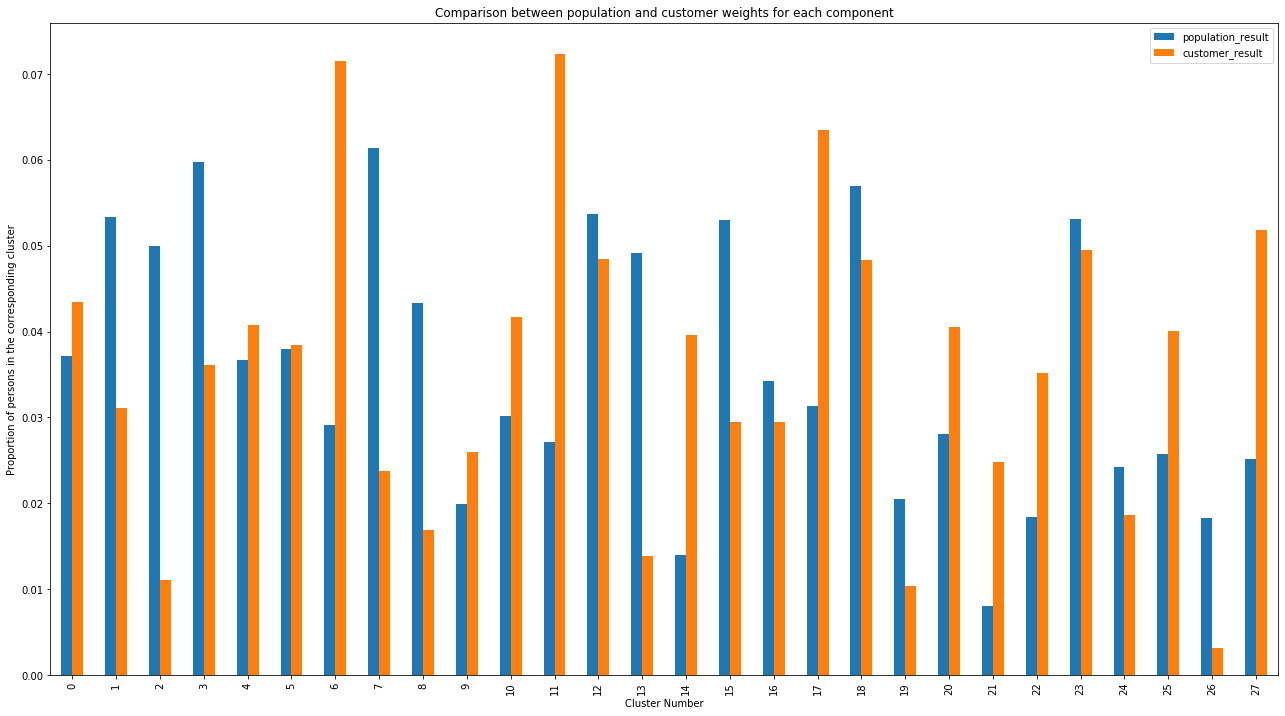

In [108]:
comparison.plot(x='cluster_id', y=['population_result', 'customer_result'], kind='bar', figsize=(22, 12))
plt.title('Comparison between population and customer weights for each component')
plt.xlabel('Cluster Number')
plt.ylabel('Proportion of persons in the corresponding cluster')
plt.show()



    cluster_id  population_result  customer_result  difference
11        11.0           0.027145         0.072365    0.045219
6          6.0           0.029183         0.071500    0.042317
17        17.0           0.031337         0.063442    0.032105
27        27.0           0.025114         0.051857    0.026743


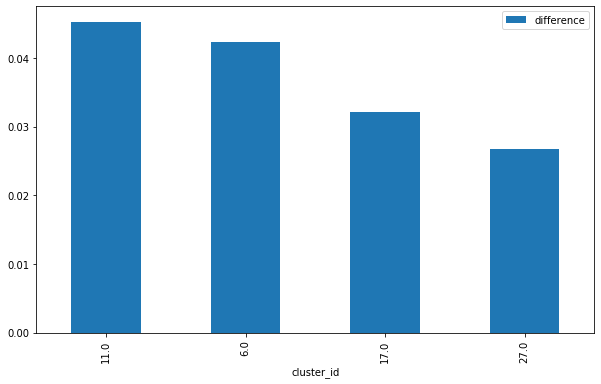

In [127]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

comparison=comparison.sort_values(by = 'difference')
#print("kinds of people are part of a cluster that is overrepresented in the customer data compared to population is cluster number ")

print('\n')
overrepresented = comparison[:4]
overrepresented = np.abs(overrepresented)
# overrepresented['difference']= overrepresented['difference'].sort_values()
print(overrepresented)
overrepresented.plot(x='cluster_id', y='difference', kind='bar', figsize=(10, 6));



kinds of people are part of a cluster that is underrepresented in the customer data compared to population is cluster number 


    cluster_id  population_result  customer_result  difference
8            8           0.043291         0.016842    0.026449
13          13           0.049202         0.013868    0.035334
7            7           0.061334         0.023793    0.037541
2            2           0.049945         0.011032    0.038913


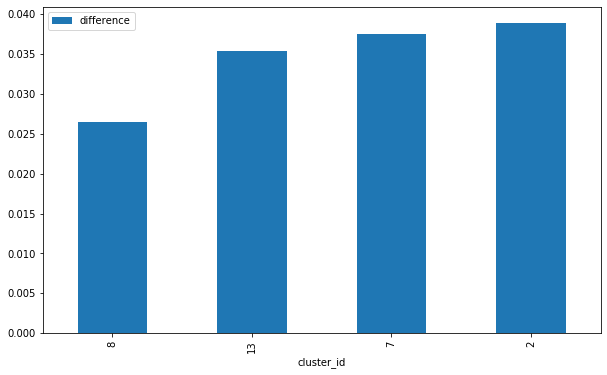

In [113]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
print("kinds of people are part of a cluster that is underrepresented in the customer data compared to population is cluster number ")
print('\n')
underrepresented = comparison[-4:]
print(underrepresented)
underrepresented.plot(x='cluster_id', y='difference', kind='bar', figsize=(10, 6))


In [117]:
# lets examine pepole distribution between customers and populations for top 2 overrepresented components
#which are components 11 and 6

# for components 11
cluster_center_11 = Kmeans_customers.cluster_centers_[11]
cluster_center_11 = pd.Series(cluster_center_11)
cluster_center_11.sort_values(ascending=False, inplace=True)
print(cluster_center_11.head(2))
cluster_center_11 = my_scaler.inverse_transform(pca.inverse_transform(cluster_center_11))
cluster_center_11 = pd.Series(cluster_center_11)
cluster_center_11.index = customers_clean.columns

print('\n\n')
# for components 6
cluster_center_6 = Kmeans_customers.cluster_centers_[6]
cluster_center_6 = pd.Series(cluster_center_6)
cluster_center_6.sort_values(ascending=False, inplace=True)
print(cluster_center_6.head(2))
cluster_center_6 = my_scaler.inverse_transform(pca.inverse_transform(cluster_center_6))
cluster_center_6 = pd.Series(cluster_center_6)
cluster_center_6.index = customers_clean.columns


1     1.704412
13    0.575283
dtype: float64



3    3.878591
6    0.396285
dtype: float64


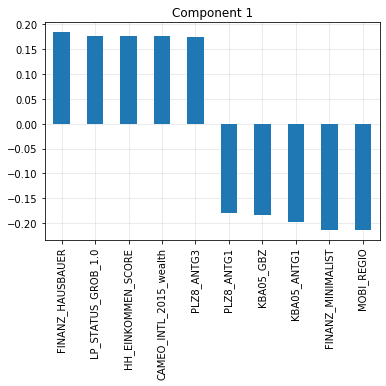

In [118]:
 component_plot(customers_clean, pca, 1)

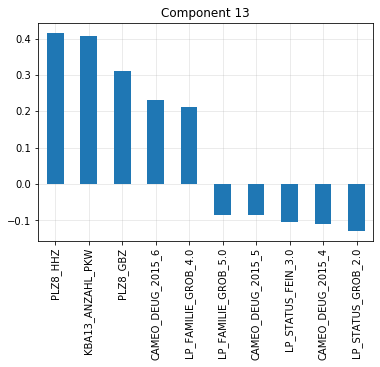

In [119]:
 component_plot(customers_clean, pca, 13)

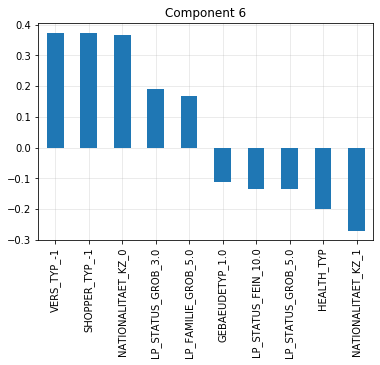

In [121]:
 component_plot(customers_clean, pca, 6)

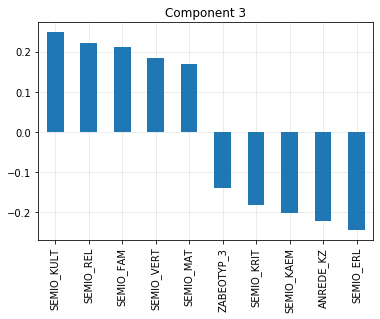

In [123]:
 component_plot(customers_clean, pca, 3)

In [129]:
# lets examine pepole distribution between customers and populations for top 2 underrepresented components
#which are components 2 and 7

# for components 2
cluster_center_2 = Kmeans_customers.cluster_centers_[2]
cluster_center_2 = pd.Series(cluster_center_2)
cluster_center_2.sort_values(ascending=False, inplace=True)
print(cluster_center_2.head(2))
cluster_center_2 = my_scaler.inverse_transform(pca.inverse_transform(cluster_center_2))
cluster_center_2 = pd.Series(cluster_center_2)
cluster_center_2.index = customers_clean.columns

print('\n\n')
# for components 7
cluster_center_7 = Kmeans_customers.cluster_centers_[7]
cluster_center_7= pd.Series(cluster_center_7)
cluster_center_7.sort_values(ascending=False, inplace=True)
print(cluster_center_7.head(2))
cluster_center_7 = my_scaler.inverse_transform(pca.inverse_transform(cluster_center_7))
cluster_center_7 = pd.Series(cluster_center_7)
cluster_center_7.index = customers_clean.columns

5    13.181704
6     7.823439
dtype: float64



0     1.900845
21    1.688642
dtype: float64


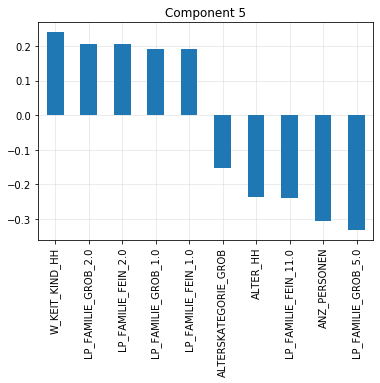

In [131]:
 component_plot(customers_clean, pca, 5)

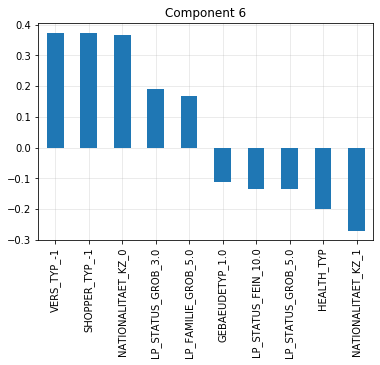

In [132]:
 component_plot(customers_clean, pca, 6)

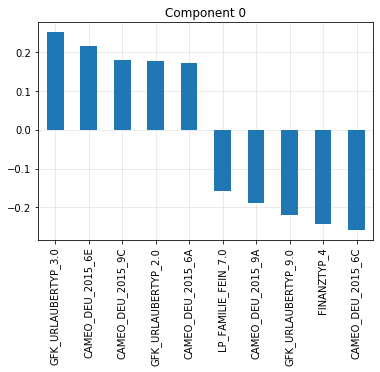

In [133]:
 component_plot(customers_clean, pca, 0)

GFK_URLAUBERTYP_3.0
CAMEO_DEU_2015_6E 
CAMEO_DEU_2015_9C
GFK_URLAUBERTYP_2.0
CAMEO_DEU_2015_6A
LP_FAMILIE_GROB_3.0
LP_FAMILIE_FEIN_5.0
LP_FAMILIE_FEIN_4.0
LP_FAMILIE_FEIN_3.0
CAMEO_DEUG_2015_1

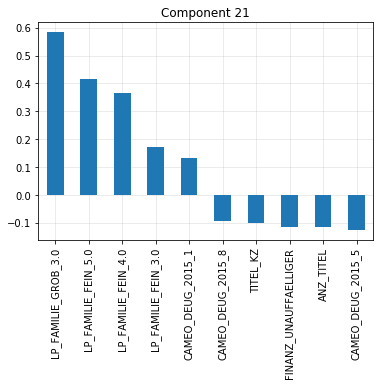

In [134]:
 component_plot(customers_clean, pca, 21)

### Discussion 3.3: Compare Customer Data to Demographics Data

#### First i will discuss overrepresented clusters:

After doing our analysis and perform **PCA** Then run one of **Unsupervised learning algorithms** which is **KMeans** for population data and customer data then compare between Both result to figure out which components is overrepresented and which are underrepresented. then the result is as the following **Clusters 11,6,17,27 ** for overrepresented and **clusters 7,2,8,13** for underrepresented but i will focus on top 2 cluster for each one first for overrepresented clusters

#### Cluster_11

1. FINANZ_HAUSBAUER
2. LP_STATUS_GROBS_1.0 --> Social status, rough scale low-income earners (maps to 1-2 in fine scale)
3. HH_EINKOMMEN_SCORE --> Estimated household net income (higher is lower income)
4. CAMEO_INTEL_2015_WEALTH --> Household wealth (higher is lower income)
5. PLZ_ANTG3 
6. PLZ8_HHZ
7. KBA13_ANZAHL_PKW 
8. PLZ8_GBZ
9. CAMEO_DEUG_2015_6

#### Cluster_6

1. VERS_TYP_-1 --> Insurance typology for the unknown
2. sHOPPER_TYP_-1 --> Shopper typology unknown
3. NATIONALITATE_KZ_0 --> Nationality based on given name analysis 0 for UNKOWN
4. LP_STATUS_GROB_3.0 --> single parent (maps to 3-5 in fine scale)
5. LP_STATUS_GROB_5.0 --> multiperson household (maps to 9-11 in fine scale)
6. SEMIO_KULT  --> Personality typology, - KULT: cultural-minded
7. SEMIO_REL -->  (Religious personality type)
8. SEMIO_FAM  --> personality topology for family-minded
9. SEMIO_VERT --> Personality typology, dreamful (higher is lower affinity)
10. SEMIO_MAT --> personality topology for materialistic

#### Second i will discuss underrepresented clusters:


#### Cluster_2

1. W_KEIT_KIND_HH
2. LP_FAMILIE_GROB_2.0 --> Family type, rough scale couple (maps to 2 in fine scale)
3. LP_FAMILIE_FEIN_2.0 --> Family type, fein scale couple
4. LP_FAMILIE_GROB_1.0 --> Family type, rough scale single (maps to 1 in fine scale)
5. LP_FAMILIE_FEIN_1.0 --> Family type, fein scale single
6. VERS_TYP_1 --> Insurance typology social safety driven
7. SHOPPER_TYP_1 --> Shopper typology shopping-stressed
8. NATIONALITATE_KZ_0
9. LP_STATUS_GROB_3.0 --> Social status, rough scale low income earner
10. LP_STATUS_GROB_5.0 --> Social status, rough scale average earner

#### Cluster_7

1. GFK_URLAUBERTYP_3.0 --> Vacation habits Winter sportspeople
2. CAMEO_DEU_2015_6E  --> German CAMEO: Wealth / Life Stage Typology, detailed scale Urban Parents
3. CAMEO_DEU_2015_9C --> German CAMEO: Wealth / Life Stage Typology, detailed scale Afternoon Talk Show
4. GFK_URLAUBERTYP_2.0 --> Vacation habits Family-oriented vacationists
5. CAMEO_DEU_2015_6A  --> German CAMEO: Wealth / Life Stage Typology,jobstarter
6. LP_FAMILIE_GROB_3.0 --> single parent (maps to 3-5 in fine scale)
7. LP_FAMILIE_FEIN_5.0 --> Family type, fine scale single parent with child of full age
8. LP_FAMILIE_FEIN_4.0 --> Family type, fine scale single parent with teenager
9. LP_FAMILIE_FEIN_3.0 --> Family type, fine scale young single parent
10. CAMEO_DEUG_2015_1


#### Finidings:
Clusters 6 and 11 are top of the clusters overrepresented in the customer data compared to the general population. Looking at most 2 influencing components and their weights, the cluster represent wealthy materialistic family minded and dreamful religious and live in house consist of large family they are not good choice for mail order while,Clusters 7 and 2 are top of the clusters underrepresented in the customer data compared to the general population. Looking at most 2 influencing components and their weights, family type of (single-couple-single parent with or without child) feeling stressed when they go to shopping and they are jobstarter or urban parents this group fit in a good way more than the first one for mail order


### Finally

This real life demographic data provided by Arvato , gave me the chance to create segmentation of customers and I was able able to identify key features that will help identify customers for the company. To sum up, since there is a small difference between nearly half of the predictions demographics of the general populations and the customer data, we can recommend the Arvato company to use these information to select part of the general population for their business. keeping in mind that some columns were removed which may contain some information that could lead to different findings.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.